<big>Основной вывод:</big> V1

- Качество: Модель обучения <b>LightGBM</b> показала метрику <b>RSME = 1118.75</b> что на <b>1118.75 лучше</b> необходимого.
- Время обучения: Модель <b>LightGBM</b> самая требовательная по времени из расмотренных, и отличается в разы.
- Скорость предсказания: У модели <b>LightGBM</b> дольше всего происходит предсказание.

- Другие модели тоже справляются, резултат около 2000 хуже чем у <b>LightGBM</b>, но гораздо быстрее.

▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
## Загрузка библиотек, объявление функций и установка констант
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀

In [2]:
!pip install -U scikit-learn # Обновим библиотеку, т.к. возникала ошибка

In [3]:
import time

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
# ▼ графики встраиваются в блокнот
%matplotlib inline
# ▼ векторный формат отображения
%config InlineBackend.figure_format = 'svg'

import lightgbm

# ▼ sklearn
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier # классификации деревом решений
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score

from sklearn.compose import make_column_transformer

In [4]:
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

In [5]:
# Время и дата выполнения ячейки
t = time.localtime(time.time())
a = str(f'{t[0]}/{t[2]}/{t[3]}-{t[3]}:{t[4]}')
print(a)

2023/12/16-16:52


### Константы

In [6]:
# Константы проекта
DATA = ['/datasets/autos.csv', 'https://code.s3.yandex.net/datasets/autos.csv']

COUNT = 1000 # Константа количества записей менее которого не рассматриваются

AGREGATE_AUTO = ['Brand', 'Model'] # характеристики обьедененого столбца

RESULT = 2500 # Верхняя граница RSME, чем лучше тем ниже значение

RANDOM_STATE = 42

### Функции

#### Напишем функцию Расчета процентиля

In [7]:
def percen(d, left, right): 
    # d - Данные, left - левая граница процентиля, right - правая граница процентиля

    percen = d[d > 0].dropna() # отбросим 0 и Nan
    percen_lim = [np.percentile(percen, left), np.percentile(percen, 100 - right)]

    data_percen_lim = percen[(percen > percen_lim[0])&(percen < percen_lim[1])]

    print('Процентиль', left + right,'%')
    print('Диапозон', int(percen_lim[0]),'->', int(percen_lim[1]))
    print(data_percen_lim.count(),'-->', round(data_percen_lim.dropna().count() / (percen.count()/100), 1),'%')
    print('--------------------------')

#### Напишем функцию Градиентного спуска

In [8]:
class SGDLinearRegression:
    
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        
    def fit(self, train_features, train_target):
        X =np.concatenate((np.ones((train_features.shape[0],1)),train_features),axis=1)
        y = train_target
        w = np.zeros(X.shape[1])        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                gradient = 2*X_batch.T.dot(X_batch.dot(w)-y_batch)/X_batch.shape[0]
                w -= self.step_size * gradient
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

#### Напишем функцию Гребневая регрессия

In [9]:
class RidgeRegression:
    
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight
        
    def fit(self, train_features, train_target):
        X =np.concatenate((np.ones((train_features.shape[0],1)),train_features),axis=1)
        y = train_target
        w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                gradient = 2*X_batch.T.dot(X_batch.dot(w)-y_batch)/X_batch.shape[0]
                reg = 2 * w.copy()
                reg[0] = 0
                gradient += self.reg_weight * reg
                w -= self.step_size * gradient
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
## Подготовка данных
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀

### Загрузка данных

In [10]:
# Загружаем данные
try:
    data = pd.read_csv(DATA[0])
except:
    data = pd.read_csv(DATA[1])

### Общая информация exploratory data analysis, EDA

In [11]:
data.shape

(354369, 16)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- Необходимо изменить тип данных в некоторых столбцах, с <b>object</b> на <b>int</b>, или <b>float</b> в зависимости от содержания
- Необходимо изменить тип данных в столбцах c информацией о дате с <b>object</b>, <b>int</b> на <b>datatype</b> при этом необходимо объеденить <b>RegistrationYear</b> и <b>RegistrationMonth</b>

In [13]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


- в данных присутствуют недопустимые значения, например в столбце <b>RegistrationMonth</b> есть 0 месяц, необходимо предобработать данные и отбросить анномалии по всей таблице.

In [14]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

- Наименование столбцов в Camel стиле (приемлемо), написание правильное.

In [15]:
# смотрим discribe числовых данных
data.select_dtypes(include=['float64', 'int64']).describe(include='all')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Замечания:
- <b>Price</b> Необходимо посмотреть на выбросы, присутствуют нереальное значение.
- <b>RegistrationYear</b> Присутствуют нереальное значение, необходимо предобработать.
- <b>Power</b> мощность (л. с.) Необходимо посмотреть на выбросы, 20_000 л. с. нереальное значение.
- <b>Kilometer</b> Выбросов нет, 150_000 это реалная цифра, но нужно проверить осуществлялся ремонт или нет. Производители закладывают что срок службы истекает после 150_000 км. если ремонта небыло то он явно скоро будет. 
- <b>RegistrationMonth</b> В основном машины покупают во 2-й половине года
- <b>NumberOfPictures</b> В столбце нет данных, отбросим

### Детальное расмотрение данных

#### Значения Nan в данных

In [16]:
# Смотрим сколько значений Nan в данных и в каких столбцах
columns_name = data.columns
for i in range(len(columns_name)):
    isna = data[columns_name[i]].isna().sum()
    if isna != 0:
        print(columns_name[i], '-->', isna, '-->',round((isna / (data.shape[0]+isna))*100), '%')

VehicleType --> 37490 --> 10 %
Gearbox --> 19833 --> 5 %
Model --> 19705 --> 5 %
FuelType --> 32895 --> 8 %
Repaired --> 71154 --> 17 %


Вывод:
- <b>VehicleType</b> — Можно попробовать востановить по другим значениям, если неполучится заполнить 'uncknow'
- <b>Gearbox</b> — Можно попробовать востановить по другим значениям, если неполучится заполнить 'uncknow'
- <b>Model</b> — Можно попробовать востановить по другим значениям, если неполучится заполнить 'uncknow'
- <b>FuelType</b> — Можно попробовать востановить по другим значениям, если неполучится заполнить 'uncknow' 
- <b>Repaired</b> — Востановить нет возможности заполним 'uncknow'

Примечание:
- Можно попробовать написать код для поиска и заполнения отсутствующих данных, но думаю это не цель задачи и можно оставить на будующее как идею.
- Заполним отсутствующие данные как 'unknow' возможно это отдельная категория и поможет определять целевой признак более точно.

In [17]:
# Сколько целевые данные имеют значений 0?
print(data['Price'][data['Price'] == 0].count(),' --> ',\
      round(data['Price'][data['Price'] == 0].count() / (data.shape[0]/100),1), '%')

10772  -->  3.0 %


Вывод:
- Цены 0 несуществует, нужно отбросить
- Целевые данные с экстремальными значениями отбросим, возьмем процентиль 5%

In [18]:
# Смотрим сколько уникальных значений в столбцах
columns_name = data.columns
for i in range(len(columns_name)):
    unique = len(data[columns_name[i]].unique())
    print(columns_name[i], unique)

DateCrawled 271174
Price 3731
VehicleType 9
RegistrationYear 151
Gearbox 3
Power 712
Model 251
Kilometer 13
RegistrationMonth 13
FuelType 8
Brand 40
Repaired 3
DateCreated 109
NumberOfPictures 1
PostalCode 8143
LastSeen 179150


#### Посмотрим на процентили в данных

In [19]:
percen_colum = ['Price','Power']

for i in range(len(percen_colum)):
    print('Столбец','|', percen_colum[i],'|')
    percen(data[percen_colum[i]], 2.5, 2.5)

Столбец | Price |
Процентиль 5.0 %
Диапозон 200 -> 16950
326318 --> 95.0 %
--------------------------
Столбец | Power |
Процентиль 5.0 %
Диапозон 50 -> 250
295337 --> 94.0 %
--------------------------


In [20]:
# Посчитаем процентиль 5% редких моделей авто
percen(data['Model'].value_counts(), 5, 0)

Процентиль 5 %
Диапозон 16 -> 29232
236 --> 94.4 %
--------------------------


- Считаю что можно убрать записи которых меньше 15, слишком мало для анализа

In [21]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [22]:
data['FuelType'].isna().sum()

32895

- Заполним Nan на 'unknow'

In [23]:
data['Kilometer'].value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

In [24]:
data['Kilometer'].isna().sum()

0

- в основном размещают машины с большим пробегом (на гране окончания гарантии)

In [25]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [26]:
data['Gearbox'].isna().sum()

19833

- Преобладают машины с ручной коробкой передачи
- Заполним Nan на 'unknow'

In [27]:
data['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

In [28]:
data['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

In [29]:
data['Brand'].isna().sum()

0

- Есть мысл создать словари с существующими наименованиями моделей и характеристик (двигатель, коробка, кузов и т.д.) для проверки заполнения данных и отсечения ошибок, но думаю это выходит за рамки данного проекта.

In [30]:
# Смотрим сколько имеется значений в 'RegistrationYear' которые не входят в 40 летний диапозон
# их стоит отбросить
year1 = 1983
year2 = 2023
print(year1,'< <', year2)
print((data[columns_name[3]] < year1).sum(),'< <',\
      (data[columns_name[3]] > year2).sum())

1983 < < 2023
4619 < < 105


- Стоит отбросить значения которые не входя в 40 летний диапозон

In [31]:
print(data['DateCrawled'].head(3))
print(data['RegistrationYear'].head(3))

0    2016-03-24 11:52:17
1    2016-03-24 10:58:45
2    2016-03-14 12:52:21
Name: DateCrawled, dtype: object
0    1993
1    2011
2    2004
Name: RegistrationYear, dtype: int64


#### Дубликаты

In [32]:
# Смотрим наличие дубликатов в строках
data.duplicated().sum()

4

- Присутствую дубликатов отбросим

####  Общие замечание по данным:

- Наименование столбцов без ошибок, не требуются правки.
- Имеются значения <b>Nan</b> в категориалных данных, заполним их значением <b>'unknown'</b>.
- В данных имеются 4 строки дубликатов, отбросим.
- Данные имеют неподходящие типы, предобработаем.
- В столбце с целевым признаком имеются выбросы которые могут затруднить обучение, отбросим
- Имеются нереальные выбросы в столбце <b>'RegistrationYear'</b>, отбросим
- В столбце <b>PostalCode</b> много значений, в данном виде мы не можем их перевести в категориальный вид. Отбросим.
- После расмотрения типа данных пришел к выводу что необходимо сократить кол. категориальных данных и сагрегировать столбцы: 'Brand', 'Model', 'Gearbox', 'FuelType'. И из новых данных посмотреть сколько категорий получилось. Для более удобного изменения создадим константу.

In [33]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

#### <b>Замечания по столбцам:</b>

- 0   <b>DateCrawled</b> — дата скачивания анкеты из базы
    - | object |
    - Отбросим столбец. Совпадает с данными DateCreated, но в DateCrawled есть время. Время для нашей работы неимеет значение, важнее знать когда объявление создано. Дата скачивания анкеты нас не интересует.


- 1   <b>Price</b> — цена (евро) <b>Целевой признак</b>
    - | int64  |
    - Имеются выбросы и 0 значения. Возьмем процентиль.
    - Возьмем строки со значением согласно процентилю 200 -> 16950
    

- 2   <b>VehicleType</b> — тип автомобильного кузова 
    - | object |
    - Имеются значения Nan, заполним их значением 'unknow'.


- 3   <b>RegistrationYear</b> — год регистрации автомобиля
    - | int64 | перевести тип в Data.
    - Имеются нереальные выбросы в столбце, отбросим.
    
    
- 4   <b>Gearbox</b> — тип коробки передач
    - | object |
    - есть бесмысленные значения (например '0') заменим их на <b>'unknow'</b>.
    - Присутствуют Nan заменим их на <b>'unknown'</b>.


- 5   <b>Power</b> — мощность (л. с.)
    - | int64 |
    - Имеются выбросы и нереальные значения. Возьмем процентиль.
    - Возьмем строки со значением согласно процентилю 50 -> 250.
    
    
- 6   <b>Model</b> — модель автомобиля
    - | object |
    - Считаю стоит убрать редких модели авто, возьмем процентиль 5% и уберем редкие авто.


- 7   <b>Kilometer</b> — пробег (км)
    - | int64 | 
    - С данными все впорядке.
    
    
- 8   <b>RegistrationMonth</b> — месяц регистрации автомобиля
    - | int64 | перевести тип в Data
    - Объяденить с данными в колонке <b>RegistrationYear</b> — год регистрации автомобиля.
    - Присутствуют значение '0' нужно заменить на Nan, скорей всего месяц неуказали.
    - Объядененные данные сохраним в новом столбце <b>RegistrationDate</b>.
   
   
- 9   <b>FuelType</b> — тип топлива
    - | object |
    - Присутствуют Nan заменим их на <b>'unknown'</b>.


- 10  <b>Brand</b> — марка автомобиля
    - | object |
    - Отбросим редкие марки авто.


- 11  <b>Repaired</b> — была машина в ремонте или нет
    - | object | Необходимо перевести тип в int и преобразовать в бинарный 1-да 0-нет.
    - Создать еще один столбец <b>InfoRepaired</b> бинарный типом данных (1 - Есть информация, 0 - Нет информации).


- 12  <b>DateCreated</b>
    - | object | перевести тип в Data.
    - Данные округлить до дня.


- 13  <b>NumberOfPictures</b> — количество фотографий автомобиля
    - | int64 | 
    - Отбросим столбец так как в нем нет информации.


- 14  <b>PostalCode</b> почтовый индекс владельца анкеты (пользователя)
    - | int64 |
    - Следует расчитывать как категориальные данные, и перевести их в object.
    - По почтовому индексу можно предположить место дислокации, возможно от этого зависит цена.
    - Значений оцень много, для работы с этими данными необходимо сгрупировать индексы хотябы по странам или регионам. Отбросим их и оставим на будущую работу по улучшению.
    
    
- 15  <b>LastSeen</b> дата последней активности пользователя
    - | object | перевести тип в Data.
    - Влияет на достоверность объявления (если давно неактивен то либо автомобиль продан либо могло измениться характеристика авто).
    - Можно перевести в бинарное значение (1 был активен в течение 6 месяцов или 0 если нет) промежуток активности нужно подобрать и уточнить, создадим константу.

### Обработка данных

Изменения будем проводить в скопированных данных df

In [34]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'])
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])

In [35]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [36]:
# скопируем в df нужные данные, столбцы с датами добавим после обработки
df = data[['Price', 'VehicleType', 'Gearbox', 'Power', 
          'Model', 'Kilometer', 'FuelType', 'Brand',
          'Repaired', 'PostalCode'
         ]].copy()
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,70435
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,90480


In [37]:
columns_name

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [38]:
df.columns

Index(['Price', 'VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'Repaired', 'PostalCode'],
      dtype='object')

#### Обработаем столбцы с датами

##### ● 3 <b>RegistrationYear</b> — год регистрации автомобиля
    - | int64 | перевести тип в Data.
    - Имеются нереальные выбросы в столбце, отбросим.

In [39]:
data['RegistrationYear'].isna().sum()

0

In [40]:
data['RegistrationYear'].max()

9999

In [41]:
data['RegistrationYear'].min()

1000

In [42]:
data['RegistrationYear'].astype('int')

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
354364    2005
354365    2005
354366    2000
354367    1996
354368    2002
Name: RegistrationYear, Length: 354369, dtype: int64

In [43]:
# Возьмем только те данные которые не старше 40 лет давности
year2 = 2023
year1 = year2 - 40
df = data[['Price', 'VehicleType', 'Gearbox', 'Power', 
          'Model', 'Kilometer', 'FuelType', 'Brand',
          'Repaired', 'PostalCode', 'RegistrationYear',
          'RegistrationMonth', 'LastSeen', 'DateCreated'
         ]][(data[columns_name[3]] > year1) & (data[columns_name[3]] < year2)]

In [44]:
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,RegistrationYear,RegistrationMonth,LastSeen,DateCreated
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,70435,1993,0,2016-04-07 03:16:57,2016-03-24 00:00:00
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,66954,2011,5,2016-04-07 01:46:50,2016-03-24 00:00:00
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,90480,2004,8,2016-04-05 12:47:46,2016-03-14 00:00:00


In [45]:
#V1 Отбросим столбец 'RegistrationMonth'
df = df.drop('RegistrationMonth', axis=1);

In [46]:
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,RegistrationYear,LastSeen,DateCreated
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,70435,1993,2016-04-07 03:16:57,2016-03-24 00:00:00
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,66954,2011,2016-04-07 01:46:50,2016-03-24 00:00:00
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,90480,2004,2016-04-05 12:47:46,2016-03-14 00:00:00


In [47]:
# Сколько дне прошло с момента регистрации авто до размещения объявления
# в 'auto_old' запишем разницу от момента регистрации до момента размещения объявления
base_date = df[columns_name[12]].min()
df['auto_old'] = (pd.to_datetime(df['DateCreated']) - pd.to_datetime(df['RegistrationYear'])).dt.days

##### ● 12  <b>DateCreated</b> дата создания
    - | object | перевести тип в Data.
    - Данные округлить до дня.

In [48]:
pd.to_datetime(data[columns_name[12]]).max()-pd.to_datetime(data[columns_name[12]]).min()

Timedelta('759 days 00:00:00')

In [49]:
print(round(759/365))

2


- В <b>DateCreated</b> присутствует информация о 2-х годах

In [50]:
data[columns_name[12]].min()

'2014-03-10 00:00:00'

In [51]:
data[columns_name[12]].max()

'2016-04-07 00:00:00'

In [52]:
# приведем данные к типу data
df[columns_name[12]] = pd.to_datetime(data[columns_name[12]])

In [53]:
# В 'DateCreated' запишем количество дней сколько прошло с момента размещения объявления days_was_posted
df['days_was_posted'] = (pd.to_datetime(df['DateCreated']) - df['DateCreated'].min()).dt.days

#####  ● 15  <b>LastSeen</b> дата последней активности пользователя
    - | object |
    - пока просто поменяем тип данных, переведем в data type
    - Влияет на достоверность объявления (если давно неактивен то либо автомобиль продан либо могло измениться характеристика авто).

In [54]:
# приведем данные к типу data
df[columns_name[15]] = pd.to_datetime(data[columns_name[15]])

In [55]:
# Сколько дней прошло с момента публикации до последнего посещения
df['days_was_seen'] = (pd.to_datetime(df['LastSeen']) - df['DateCreated'].min()).dt.days

# Отбросим старый столбец с датой
df = df.drop('LastSeen', axis=1);
df = df.drop('DateCreated', axis=1);

In [56]:
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,RegistrationYear,auto_old,days_was_posted,days_was_seen
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,70435,1993,16883,745,759
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,66954,2011,16883,745,759
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,90480,2004,16873,735,757


#### Обработка данных по столбцам

##### ● 1 <b>Price</b>. Цена целевой признак.
- | int64  |
- Имеются выбросы и 0 значения. Возьмем процентиль.
- Возьмем строки со значением согласно процентилю 200 -> 16950

In [57]:
# Смотрим уникальные значения в столбце
print(df[columns_name[1]].value_counts())

0        10312
500       5621
1500      5319
1000      4607
1200      4561
         ...  
13885        1
934          1
4516         1
2215         1
8188         1
Name: Price, Length: 3706, dtype: int64


In [58]:
# Возьмем строки со значением согласно процентилю 200 -> 16950
df = df[(df['Price'] > 200) & (df['Price'] < 16950)]

# df = df.loc[(df[columns_name[1]]!=0)] # Отбросим 0 значения (пример кода, для себя)

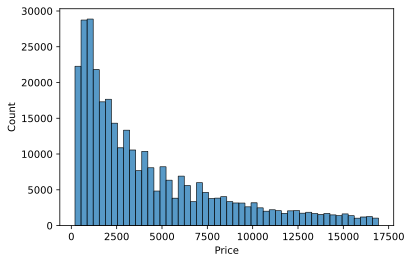

In [59]:
sns.histplot(df['Price'], bins=50);

##### ● 2   <b>VehicleType</b> — тип автомобильного кузова 
    - | object |
    - Имеются значения Nan, заполним их значением 'unknow'.

In [60]:
# Смотрим уникальные значения в столбце
print(columns_name[2], df[columns_name[2]].unique())

VehicleType [nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']


- Заполним Nan на 'unknow'

In [61]:
df[columns_name[2]] = df[columns_name[2]].fillna('unknown')

In [62]:
# Проверим изменения
print(columns_name[2], df[columns_name[2]].unique())

VehicleType ['unknown' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe'
 'other']


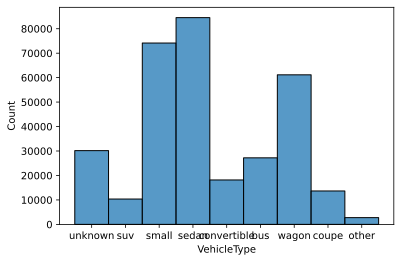

In [63]:
# Посмотрим Тип автомобильного кузова
sns.histplot(df[columns_name[2]], bins=9);

- Топ 3 автомобильных кузовов Sedan, Small, Wagon

##### ● 4 <b>Gearbox</b> — тип коробки передач
    - | object |
    - Присутствуют Nan заменим их на unknown.

In [64]:
# Заменим Nan на 'unknown'
df[columns_name[4]] = df[columns_name[4]].fillna('unknown')

In [65]:
df[columns_name[4]].value_counts()

manual     248219
auto        59456
unknown     14439
Name: Gearbox, dtype: int64

- В основном размещают машины с ручной коробко передачи

##### ● 5 <b>Power</b> — мощность (л. с.)
    - | int64 |
    - Имеются выбросы и нереальные значения. Возьмем процентиль.
    - Возьмем строки со значением согласно процентилю 50 -> 250.

In [66]:
df = df[(df['Power'] > 50) & (df['Power'] < 250)]

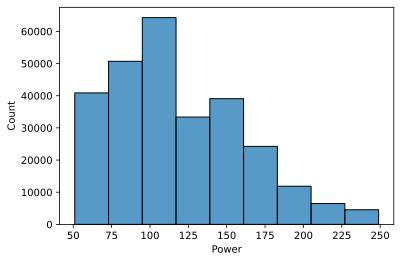

In [67]:
sns.histplot(df[columns_name[5]], bins=9);

##### ● 6 <b>Model</b> — модель автомобиля
    - | object |
    - Модель автомобиля это один из главных показателей, избавимся от Nan

In [68]:
print('Количество Nan в колонке', columns_name[6],':', df[columns_name[6]].isna().sum())

Количество Nan в колонке Model : 10156


In [69]:
# отюросим Nan в колонке 'Model'
df = df.dropna(subset=['Model'])
# Проверим изменения
print('Количнство Nan в колонке', columns_name[6],':', df[columns_name[6]].isna().sum())

Количнство Nan в колонке Model : 0


In [70]:
# Посмотрим какие самые распространенные модели авто
df[columns_name[6]].value_counts().loc[lambda x : x > 5000].to_frame()

,Model
golf,24534
other,17145
3er,16880
astra,9149
corsa,8824
polo,8762
passat,8690
a4,8485
c_klasse,7008
5er,6356


##### ● 7   <b>Kilometer</b> — пробег (км)
    - | int64 | 
    - С данными все впорядке.

In [71]:
df[columns_name[7]].isna().sum()

0

In [72]:
df[columns_name[7]].value_counts()

150000    178817
125000     28729
100000     11287
90000       9116
80000       7902
70000       6734
60000       5828
50000       4766
40000       3707
30000       3145
20000       2516
5000        2060
10000        642
Name: Kilometer, dtype: int64

##### ● 9 <b>FuelType</b> — тип топлива
    - | object |
    - Присутствуют Nan заменим их на 'unknown'.

In [73]:
df[columns_name[9]].isna().sum()

14220

- Заполним Nan на 'unknow'

In [74]:
df[columns_name[9]] = df[columns_name[9]].fillna('unknown')

In [75]:
df[columns_name[9]].value_counts().to_frame()

,FuelType
petrol,165296
gasoline,81050
unknown,14220
lpg,3976
cng,473
hybrid,166
other,39
electric,29


##### ● 10  <b>Brand</b> — марка автомобиля
    - | object |
    - Отбросим редкие марки авто.

In [76]:
df[columns_name[10]].value_counts()

volkswagen       57568
opel             29868
bmw              28499
mercedes_benz    23765
audi             22717
ford             18824
renault          13381
peugeot           8626
fiat              6980
seat              5115
skoda             4752
mazda             4441
citroen           4006
toyota            3905
nissan            3704
smart             3486
hyundai           2928
mini              2738
volvo             2575
mitsubishi        2335
honda             2307
kia               1977
alfa_romeo        1833
suzuki            1818
chevrolet         1237
chrysler          1040
dacia              804
subaru             552
daihatsu           522
jeep               495
saab               427
daewoo             375
land_rover         366
lancia             340
rover              315
jaguar             288
porsche            200
lada               137
trabant              3
Name: Brand, dtype: int64

In [77]:
# Удалим редкие марки авто.
df = df[df[columns_name[10]] != 'trabant'] # Захарткодил, не смог найти гибкое решение, рад буду за подсказку как?

##### ● 11  <b>Repaired</b> — была машина в ремонте или нет

    - | object | Необходимо перевести тип в int и преобразовать в бинарный 1-да 0-нет.
    - Создадим еще один столбец Repaired_info с бинарным типом данных (1 - Есть информация, 0 - Нет информации).

In [78]:
df[columns_name[11]].value_counts().to_frame()

,Repaired
no,203099
yes,24475


In [79]:
# Добавим столбец есть информация о ремонте или нет
bool_val = df[columns_name[11]].isna() == False
df['repaired_info'] = np.multiply(bool_val, 1)

- поменяем значения 'Repaired' на битовые и переведем тип данных в int, NaN запишем как 0. Информация об отсутствие данных 'Repaired' записали в новый столбец 'Repaired_info'

In [80]:
# Меняем значения на int 1 0
df.loc[df[columns_name[11]] == 'yes', columns_name[11]] = 1
df.loc[df[columns_name[11]] == 'no', columns_name[11]] = 0
df[columns_name[11]] = df[columns_name[11]].fillna(0)
df[columns_name[11]].value_counts()

0    240771
1     24475
Name: Repaired, dtype: int64

##### ● 14  <b>PostalCode</b> почтовый индекс владельца анкеты (пользователя)
    - | int64 |
    - По почтовому индексу можно предположить место дислокации, возможно от этого зависит цена.

In [81]:
df[columns_name[14]].value_counts()

10115    694
65428    483
66333    244
52525    233
48249    227
        ... 
75337      1
99102      1
72369      1
7950       1
79685      1
Name: PostalCode, Length: 8082, dtype: int64

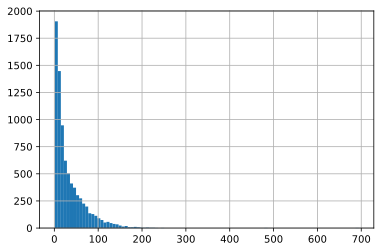

In [82]:
df[columns_name[14]].value_counts().hist(bins=100);

- Очень много индивидуалных значений, стои попробовать их сагрегировать по городам или регионам или хотябы по странам. Думаю стоит эту задачу оставить на случай необходимости улучшения обучения модели.

#### Удаляем дубликаты

In [83]:
# Удаляем дубликаты оставляя последнюю запись
data.drop_duplicates(inplace=True, keep='last')
data.duplicated().sum()

0

In [84]:
df.head(5)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,RegistrationYear,auto_old,days_was_posted,days_was_seen,repaired_info
2,9800,suv,auto,163,grand,125000,gasoline,jeep,0,90480,2004,16873,735,757,0
3,1500,small,manual,75,golf,150000,petrol,volkswagen,0,91074,2001,16876,738,738,1
4,3600,small,manual,69,fabia,90000,gasoline,skoda,0,60437,2008,16890,752,758,1
5,650,sedan,manual,102,3er,150000,petrol,bmw,1,33775,1995,16894,756,758,1
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,0,67112,2004,16891,753,757,1


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265246 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             265246 non-null  int64 
 1   VehicleType       265246 non-null  object
 2   Gearbox           265246 non-null  object
 3   Power             265246 non-null  int64 
 4   Model             265246 non-null  object
 5   Kilometer         265246 non-null  int64 
 6   FuelType          265246 non-null  object
 7   Brand             265246 non-null  object
 8   Repaired          265246 non-null  int64 
 9   PostalCode        265246 non-null  int64 
 10  RegistrationYear  265246 non-null  int64 
 11  auto_old          265246 non-null  int64 
 12  days_was_posted   265246 non-null  int64 
 13  days_was_seen     265246 non-null  int64 
 14  repaired_info     265246 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 32.4+ MB


In [86]:
data_s = data.shape
df_s = df.shape

print('В процессе обработки\nпотеряли следующие данные:\n\n',
      data_s[0]-df_s[0], '- строк\n',
      data_s[1]-df_s[1], '- столбца\n')

В процессе обработки
потеряли следующие данные:

 89119 - строк
 1 - столбца



In [87]:
# Размерность обработанных данных
df.shape

(265246, 15)

#### Удаляем переменную data

- В дальнейшем нам не пригодится переменная, считаю следует освободить память

In [88]:
# удаляем переменную из памяти
del data

#### Обработаем категориалные данные

In [89]:
AGREGATE_AUTO

['Brand', 'Model']

In [90]:
# смотрим количество признаков в столбцах об авто
for i in range(len(AGREGATE_AUTO)) : print(AGREGATE_AUTO[i], len(df[AGREGATE_AUTO[i]].value_counts()))

Brand 38
Model 245


In [91]:
#V1
df['agregate_auto'] = df[AGREGATE_AUTO[0]].astype(str) + \
                      '-' + df[AGREGATE_AUTO[1]].astype(str)
df['agregate_auto'].value_counts()

volkswagen-golf     24534
bmw-3er             16880
opel-astra           9149
opel-corsa           8824
volkswagen-polo      8762
                    ...  
porsche-cayenne         2
rover-discovery         2
porsche-911             1
rover-defender          1
rover-freelander        1
Name: agregate_auto, Length: 291, dtype: int64

In [92]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,RegistrationYear,auto_old,days_was_posted,days_was_seen,repaired_info,agregate_auto
2,9800,suv,auto,163,grand,125000,gasoline,jeep,0,90480,2004,16873,735,757,0,jeep-grand
3,1500,small,manual,75,golf,150000,petrol,volkswagen,0,91074,2001,16876,738,738,1,volkswagen-golf
4,3600,small,manual,69,fabia,90000,gasoline,skoda,0,60437,2008,16890,752,758,1,skoda-fabia
5,650,sedan,manual,102,3er,150000,petrol,bmw,1,33775,1995,16894,756,758,1,bmw-3er
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,0,67112,2004,16891,753,757,1,peugeot-2_reihe


#### Вывод:

- Подготовили данные к обучению
- Закодировали категориальные данные об авто в столбце 'agregate_auto'

▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
## Обучение моделей
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀

3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

### Случайное предсказание

In [93]:
# Создадим для сравнения случайное предсказание по медиане
round_pred = pd.Series(data=df['Price'].median(), index=df['Price'].index, dtype='int64')
rmse_median = round(mean_squared_error(df['Price'], round_pred) ** 0.5, 2)

print('RMSE случайного предсказания по медиане =', rmse_median)

# Создадим для савнения случайное предсказание по средней
round_pred = pd.Series(data=df['Price'].mean(), index=df['Price'].index, dtype='int64')
rmse_mean = round(mean_squared_error(df['Price'], round_pred) ** 0.5, 2)

print('RMSE случайного предсказания по средней =', rmse_mean)

RMSE случайного предсказания по медиане = 4189.17
RMSE случайного предсказания по средней = 3961.36


По требованию нужно получить значение <b>RSME</b> меньше <b>2500</b>

### Подготовка выборок для обучения моделей.

In [94]:
# Запишем в переменные отдельно признаки и отдельно целевой признак
X = df.drop('Price', axis=1) 
y = df['Price'] # целевой признак

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [96]:
X_train.columns

Index(['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType',
       'Brand', 'Repaired', 'PostalCode', 'RegistrationYear', 'auto_old',
       'days_was_posted', 'days_was_seen', 'repaired_info', 'agregate_auto'],
      dtype='object')

In [97]:
print('Размер выборок для обучения:')
print(' X_train :', X_train.shape ,'\n',
      'y_train :', y_train.shape,'\n\n',
      
      'X_test :', X_test.shape,'\n',      
      'y_test :', y_test.shape 
     )

Размер выборок для обучения:
 X_train : (177714, 15) 
 y_train : (177714,) 

 X_test : (87532, 15) 
 y_test : (87532,)


#### Масштабирование признаков

In [98]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
ohe_features_ridge.remove('agregate_auto')
print(ohe_features_ridge)

#категориальные признаки для OHE RandomForestRegressor
# изменился состав строк возможно стоит оставить Brandи убрать 'agregate_auto'
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf.remove('Model')
ohe_features_rf

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']


['VehicleType', 'Gearbox', 'FuelType', 'Brand']

In [99]:
#численные признаки
#обратите внимание, что 'repaired' — категориальный бинарный признак.
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('Repaired') # — категориальный бинарный признак.
num_features.remove('repaired_info') # — категориальный бинарный признак.
num_features.remove('PostalCode') # — категориальный признак.
num_features

['Power',
 'Kilometer',
 'RegistrationYear',
 'auto_old',
 'days_was_posted',
 'days_was_seen']

In [100]:
models_train = set(X_train['Model'].unique())
models_test = set(X_test['Model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''
Количество уникальных значений признка "Model" 
в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''
Уникальные значения признка "Model" 
в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'''
Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''
Только в тестовой выборке есть значения: {models_test - models_train}
''')


Количество уникальных значений признка "Model" 
в обеих выборках одинаковое: False


Уникальные значения признка "Model" 
в обеих выборках одинаковые: False


Только в тренировочной выборке есть значения: {'i3', 'gl', '911', 'cayenne'}


Только в тестовой выборке есть значения: set()



In [103]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [104]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', sparse_output=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ridge[ohe_features_ridge]);

In [105]:
%%time
# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])

CPU times: user 76 ms, sys: 571 µs, total: 76.6 ms
Wall time: 74.4 ms


In [106]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)
X_train_ridge = X_train_ridge.drop('PostalCode', axis=1)
X_train_ridge = X_train_ridge.drop('agregate_auto', axis=1)
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

In [107]:
# смотрим на результат
X_train_ridge.head()

,Power,Kilometer,Repaired,RegistrationYear,auto_old,days_was_posted,days_was_seen,repaired_info,VehicleType_convertible,VehicleType_coupe,...,Brand_renault,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
71831,-0.687363,0.560682,0,-0.259314,-1.426890,-1.426890,-1.345131,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
333901,-0.050642,0.560682,1,-1.266361,0.821867,0.821867,-0.108487,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
171842,0.722519,0.560682,1,-0.091473,1.250202,1.250202,0.790890,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162222,0.495119,0.560682,0,0.579891,-1.641058,-1.641058,0.903312,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133381,0.040318,0.560682,0,-0.091473,1.250202,1.250202,0.790890,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
%%time
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
X_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ridge[ohe_features_ridge])

X_test_ridge = X_test_ridge.drop(ohe_features_ridge, axis=1)
X_test_ridge = X_test_ridge.drop('PostalCode', axis=1)
X_test_ridge = X_test_ridge.drop('agregate_auto', axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)

# смотрим на результат
X_test_ridge.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: user 13.8 s, sys: 713 ms, total: 14.5 s
Wall time: 14.5 s


,Power,Kilometer,Repaired,RegistrationYear,auto_old,days_was_posted,days_was_seen,repaired_info,VehicleType_convertible,VehicleType_coupe,...,Brand_renault,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo
169924,-0.982983,0.560682,0,0.076368,1.678537,1.678537,0.790890,1,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
71472,-1.437783,-1.977617,0,0.915573,-0.463137,-0.463137,0.903312,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176513,-0.982983,0.560682,0,-0.762838,-0.784388,-0.784388,-1.569976,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221920,1.018139,0.560682,0,1.251255,1.571453,1.571453,0.903312,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122179,0.563339,0.560682,0,0.579891,-1.426890,-1.426890,-1.682398,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# получилось одинаковое количество признаков
X_train_ridge.shape, X_test_ridge.shape

In [ ]:
# получились одинаковые признаки в тренировочной и тестовой выборках
(X_train_ridge.columns != X_test_ridge.columns).sum()

### Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

#### Обучим Ridge

In [109]:
%%time
# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

start = time.time()
gs_ridge.fit(X_train_ridge, y_train)
t_lean = time.time() - start

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}\n')

best_score: 2045.8940355617465
best_params: {'alpha': 0.2}

CPU times: user 3min 46s, sys: 2min 11s, total: 5min 58s
Wall time: 5min 58s


In [110]:
%%time
start = time.time()
model_predict = gs_ridge.predict(X_test_ridge) # Предскажем y_test
t_predict = time.time() - start

CPU times: user 240 ms, sys: 251 ms, total: 491 ms
Wall time: 493 ms


In [134]:
result = []
# Запишем результаты модели
result.append({'Модель' : 'Ridge', 
               'model' : model_ridge,
               'RMSE' : gs_ridge.best_score_ * -1,
               'Отличие от необходимого результата' 
               : round(RESULT - (gs_ridge.best_score_ * -1), 2),
               'Время обучения' : round(t_lean,3), 
               'Время предсказания' : round(t_predict,3)
             })
# Выведем значение результата модели
for key in result[0] : print(key, ':', result[0][key])

Модель : Ridge
model : Ridge(random_state=42)
RMSE : 2045.8940355617465
Отличие от необходимого результата : 454.11
Время обучения : 46.522
Время предсказания : 0.181


#### Обучим LinearRegression

In [129]:
%%time

model = LinearRegression() # запишем модель

# Произведем оценку на правильных ответах
rmse = cross_val_score(model, X_test_ridge, y_test,
                       cv = 10,
                       #V1 Заменил ->'neg_mean_squared_error'
                       scoring = 'neg_root_mean_squared_error' 
                      )
print('\nВремя выполнения ячейки:')


Время выполнения ячейки:
CPU times: user 1min 52s, sys: 2min 22s, total: 4min 14s
Wall time: 4min 15s


In [130]:
print('RMSE линейно регресии на тестовых данных:',
      round((rmse.mean() * -1)/(10**6), 2))

RMSE линейно регресии на тестовых данных: 2086.86


- <b>RMSE</b> V1 линейноу регрессии показывает значение в рамках необходимоe не более 2500, обучим и замерим время и качество.
- <b>%%time</b> -> время выполнения ячейки

In [131]:
%%time

# Обучение LinearRegression
start = time.time()
model.fit(X_train_ridge, y_train) # Обучим модель
t_lean = time.time() - start

# Предсказания LinearRegression
start = time.time()
model_predict = model.predict(X_test_ridge) # Предскажем y_test
t_predict = time.time() - start

CPU times: user 22.4 s, sys: 24.3 s, total: 46.7 s
Wall time: 46.7 s


In [132]:
# Оценим модель по кроссвалидации
rmse = cross_val_score(model, X_test_ridge, y_test,
                       cv = 10, 
                       scoring = 'neg_root_mean_squared_error'
                      )

print('RMSE линейно регресии на тестовых данных:',
      round((rmse.mean() * -1)/(10**6), 2))

RMSE линейно регресии на тестовых данных: 2086.86


In [135]:
# Запишем результаты модели
result.append({'Модель' : 'LinearRegression', 
               'model' : model,
               'RMSE' : round((rmse.mean() * -1)/(10**6), 2),
               'Отличие от необходимого результата' 
               : round(RESULT - (rmse.mean() * -1)/(10**6), 2),
               'Время обучения' : round(t_lean,3), 
               'Время предсказания' : round(t_predict,3)
             })
# Выведем значение результата модели
for key in result[1] : print(key, ':', result[1][key])

Модель : LinearRegression
model : LinearRegression()
RMSE : 2086.86
Отличие от необходимого результата : 413.14
Время обучения : 46.522
Время предсказания : 0.181


Вывод:
- LinearRegression результат хуже чем у Ridge.

#### Обучим LightGBM

In [136]:
# Запишем основные параметры - данные
train = lightgbm.Dataset(X_train_ridge, #V1 
                         label = y_train, 
                         free_raw_data = False
                        )

test = lightgbm.Dataset(X_test_ridge, 
                        label = y_test
                       )
# зараметры поиска лучшей модели
param_grid_lgbm = {'learning_rate': [0.1, 0.4, 0.7, 0.9],
                   'max_depth': [10, 15, 30, 60],
                  }

lgbm = lightgbm.LGBMRegressor(n_jobs = 10)

In [137]:
# GridSearchCV подбор лучших параметров
grid_search_lgbm = GridSearchCV(estimator = lgbm, 
                                param_grid = param_grid_lgbm, 
                                cv = 10,
                                n_jobs = -1, 
                                verbose = 0, 
                                scoring = 'neg_mean_squared_error',
                               )

In [138]:
%%time
# подберем лучшие параметры и обучим модель
start = time.time()
grid_search_lgbm.fit(X_train_ridge, y_train)
t_lean = time.time() - start
print('Резутат лучшей модели:', round((-grid_search_lgbm.best_score_) ** 0.5, 2), '\n')

Резутат лучшей модели: 1369.1 

CPU times: user 15min 1s, sys: 8min 26s, total: 23min 27s
Wall time: 23min 31s


In [139]:
%%time
# предскажем с лучшими параметрами
start = time.time()
pred_test = grid_search_lgbm.best_estimator_.predict(X_test_ridge)
t_predict = time.time() - start

# Оценим модель
rmse = mean_squared_error(y_test, pred_test) # Посчитаем RMSE для модели

print('RMSE LightGBM gradient boosting framework:', round(rmse ** 0.5, 2))
print('\nВремя обучения лучшей модели:', grid_search_lgbm.refit_time_)
print('\nВремя выполнения ячейки:')

RMSE LightGBM gradient boosting framework: 1381.25

Время обучения лучшей модели: 8.51001524925232

Время выполнения ячейки:
CPU times: user 860 ms, sys: 88.3 ms, total: 948 ms
Wall time: 981 ms


In [141]:
# Запишем результаты модели
result.append({'Модель': 'LightGBM',
               'model' : grid_search_lgbm,
               'RMSE' : round(rmse ** 0.5, 2),
               'Отличие от необходимого результата' : round(RESULT - rmse ** 0.5, 2),
               'Время обучения' : round(t_lean,3), 
               'Время предсказания' : round(t_predict,3)
             })
# Выведем значение результата модели
for key in result[2] : print(key, ':', result[2][key])

Модель : LightGBM
model : GridSearchCV(cv=10, estimator=LGBMRegressor(n_jobs=10), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.4, 0.7, 0.9],
                         'max_depth': [10, 15, 30, 60]},
             scoring='neg_mean_squared_error')
RMSE : 1381.25
Отличие от необходимого результата : 1118.75
Время обучения : 1411.223
Время предсказания : 0.98


▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
## Анализ моделей
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀

5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [142]:
result_df = pd.DataFrame(result)
result_df

,Модель,model,RMSE,Отличие от необходимого результата,Время обучения,Время предсказания
0,Ridge,Ridge(random_state=42),2045.894036,454.11,46.522,0.181
1,LinearRegression,LinearRegression(),2086.860000,413.14,46.522,0.181
2,LightGBM,"GridSearchCV(cv=10, estimator=LGBMRegressor(n_...",1381.250000,1118.75,1411.223,0.980
3,LightGBM,"GridSearchCV(cv=10, estimator=LGBMRegressor(n_...",1381.250000,1118.75,1411.223,0.980


### Вывод:

- Качество: Модель обучения LightGBM показала метрику <b>RSME = 1118.75</b> что на 1118.75 лучше необходимого.
- Время обучения: Модель LightGBM самая требовательная по времени из расмотренных, и отличается в разы.
- Скорость предсказания: У модели LightGBM дольше всего происходит предсказание.

Примечание: за качество приходиться платить временем

<big>Основной вывод:</big>

- Качество: Модель обучения <b>LightGBM</b> показала метрику <b>RSME = 1118.75</b> что на <b>1118.75 лучше</b> необходимого.
- Время обучения: Модель <b>LightGBM</b> самая требовательная по времени из расмотренных, и отличается в разы.
- Скорость предсказания: У модели <b>LightGBM</b> дольше всего происходит предсказание.

- Другие модели тоже справляются, резултат около 2000 хуже чем у <b>LightGBM</b>, но гораздо быстрее.